In [1]:
%matplotlib inline
from time import sleep
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
import matplotlib.ticker as ticker
import pandas as pd
import numpy as np
from numpy import atleast_2d
from random import shuffle
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from hdbscan import HDBSCAN
from sklearn.metrics import adjusted_mutual_info_score
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris
from sklearn.neighbors import KDTree

In [2]:
cmap = cm.get_cmap('viridis')
pd.options.display.float_format = '{:,.2f}'.format

### Load Iris Data

In [3]:
iris = load_iris()
iris.keys()

dict_keys(['data', 'target', 'target_names', 'DESCR', 'feature_names', 'filename'])

### Create DataFrame

In [4]:
features = iris.feature_names
data = pd.DataFrame(data=np.column_stack([iris.data, iris.target]), 
                    columns=features + ['label'])
data.label = data.label.astype(int)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
sepal length (cm)    150 non-null float64
sepal width (cm)     150 non-null float64
petal length (cm)    150 non-null float64
petal width (cm)     150 non-null float64
label                150 non-null int64
dtypes: float64(4), int64(1)
memory usage: 5.9 KB


### Standardize Data

In [5]:
scaler = StandardScaler()
features_standardized = scaler.fit_transform(data[features])
n = len(data)

### Reduce Dimensionality to visualize clusters

In [6]:
pca = PCA(n_components=2)
features_2D = pca.fit_transform(features_standardized)

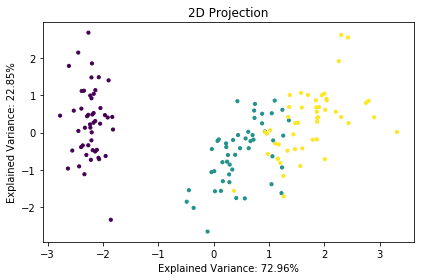

In [7]:
ev1, ev2 = pca.explained_variance_ratio_
ax = plt.figure().gca(title='2D Projection', 
                      xlabel='Explained Variance: {:.2%}'.format(ev1), 
                      ylabel='Explained Variance: {:.2%}'.format(ev2))
ax.scatter(*features_2D.T, c=data.label, s=10)
plt.tight_layout();

### Perform DBSCAN clustering

/home/stefan/.pyenv/versions/at-3.6/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


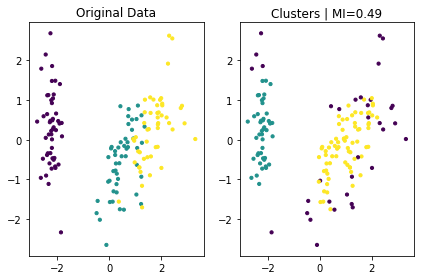

In [8]:
clusterer = DBSCAN()
data['clusters'] = clusterer.fit_predict(features_standardized)
fig, axes = plt.subplots(ncols=2)
labels, clusters = data.label, data.clusters
mi = adjusted_mutual_info_score(labels, clusters)
axes[0].scatter(*features_2D.T, c=data.label, s=10)
axes[0].set_title('Original Data')
axes[1].scatter(*features_2D.T, c=data.clusters, s=10)
axes[1].set_title('Clusters | MI={:.2f}'.format(mi))
plt.tight_layout()

### Compare parameter settings

In [9]:
eps_range = np.arange(.2, .91, .05)
min_samples_range = list(range(3, 10))
labels = data.label
mi = {}
for eps in eps_range:
    for min_samples in min_samples_range:
        clusterer = DBSCAN(eps=eps, min_samples=min_samples)
        clusters = clusterer.fit_predict(features_standardized)  
        mi[(eps, min_samples)] = adjusted_mutual_info_score(clusters, labels)

/home/stefan/.pyenv/versions/at-3.6/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/stefan/.pyenv/versions/at-3.6/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/stefan/.pyenv/versions/at-3.6/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/stefan/.pyenv/versions/at-3.6/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI wil

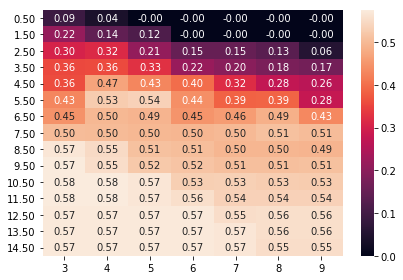

In [10]:
results = pd.Series(mi)
results.index = pd.MultiIndex.from_tuples(results.index)
fig, axes = plt.subplots()
ax = sns.heatmap(results.unstack(), annot=True, fmt='.2f')
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))
plt.tight_layout()

### Run again

/home/stefan/.pyenv/versions/at-3.6/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


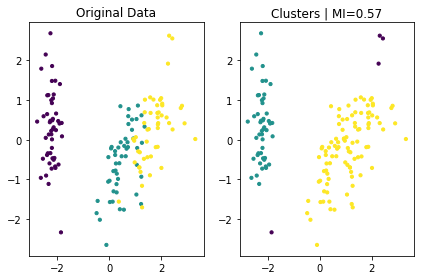

In [11]:
clusterer = DBSCAN(eps=.8, min_samples=5)
data['clusters'] = clusterer.fit_predict(features_standardized)
fig, axes = plt.subplots(ncols=2)
labels, clusters = data.label, data.clusters
mi = adjusted_mutual_info_score(labels, clusters)
axes[0].scatter(*features_2D.T, c=data.label, s=10)
axes[0].set_title('Original Data')
axes[1].scatter(*features_2D.T, c=data.clusters, s=10)
axes[1].set_title('Clusters | MI={:.2f}'.format(mi))
plt.tight_layout()


### DBSCAN in python

#### Recursive dbscan 

In [12]:
def run_dbscan(point, members):
    members.add(point)
    neighbors = kdtree.query_radius(atleast_2d(data_[point]), eps)[0]
    if len(neighbors) < min_samples:
        return members | set(neighbors)
    else:
        for neighbor in set(neighbors) - set(members):
            members.update(run_dbscan(neighbor, members))
    return members

#### Dynamic Plotting 

In [13]:
def plot_dbscan(data, assignments, axes, delay=.5):
    for ax in axes:
        ax.clear()
    xmin, ymin = data[['x', 'y']].min()
    xmax, ymax = data[['x', 'y']].max()
    data.plot.scatter(x='x', y='y', c=data.label, cmap=cmap, s=10, 
                      title='Original Data', ax=axes[0], colorbar=False)
    plot_data.clusters = plot_data.index.map(assignments.get)
    db_data= data.fillna(0)[data.clusters.notnull()]
    db_data.plot.scatter(x='x', y='y', cmap=cmap, colorbar=False, 
                         xlim=(xmin, xmax), ylim=(ymin, ymax),
                         c=db_data.clusters, s=10, title='DBSCAN', ax=axes[1])    
    fig.canvas.draw()
    sleep(delay)

#### DBSCAN Execution 

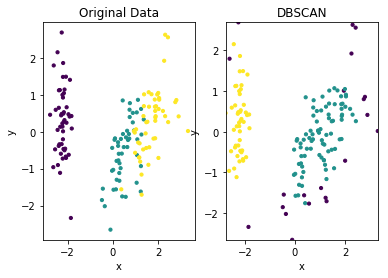

In [14]:
eps, min_samples = .6, 5
data_ = features_standardized.copy()
kdtree = KDTree(data_)

to_do = list(range(len(data_)))
plot_data = pd.DataFrame(data=np.c_[features_2D, labels],
                        columns=['x', 'y', 'label']).assign(clusters=np.nan)
shuffle(to_do)
n_clusters = 1
fig, axes = plt.subplots(ncols=2)
assignments = {}
while to_do:
    item = to_do.pop()
    neighbors = kdtree.query_radius(atleast_2d(data_[item, :]), eps)[0]
    if len(neighbors) < min_samples:
        assignments[item] = 0
        plot_dbscan(plot_data, assignments, axes)
    else:
        new_cluster = run_dbscan(item, set())
        to_do = [t for t in to_do if t not in new_cluster]
        for member in new_cluster:
            assignments.update({member: n_clusters})
        n_clusters += 1

### HDBSCAN

/home/stefan/.pyenv/versions/at-3.6/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


Text(0.5, 1.0, 'Clusters | MI=0.58')

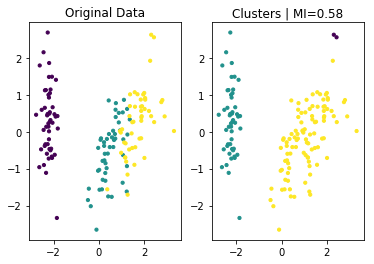

In [15]:
clusterer = HDBSCAN()
data['clusters'] = clusterer.fit_predict(features_standardized)
fig, axes = plt.subplots(ncols=2)
labels, clusters = data.label, data.clusters
mi = adjusted_mutual_info_score(labels, clusters)
axes[0].scatter(*features_2D.T, c=data.label, s=10)
axes[0].set_title('Original Data')
axes[1].scatter(*features_2D.T, c=data.clusters, s=10)
axes[1].set_title('Clusters | MI={:.2f}'.format(mi))

### Alternative Dataset 

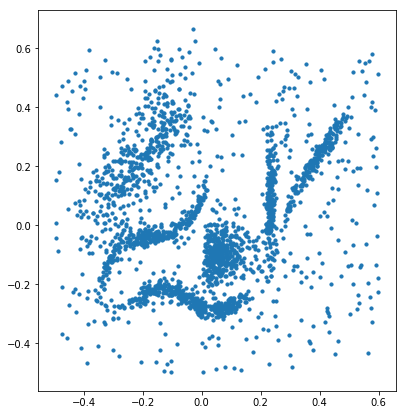

In [21]:
alternative_data = np.load('clusterable_data.npy')
fig, ax = plt.subplots(figsize=(7,7))
ax.set_aspect('equal')
ax.scatter(*alternative_data.T, s=10);

### Compare DBSCAN & HDBSCAN 

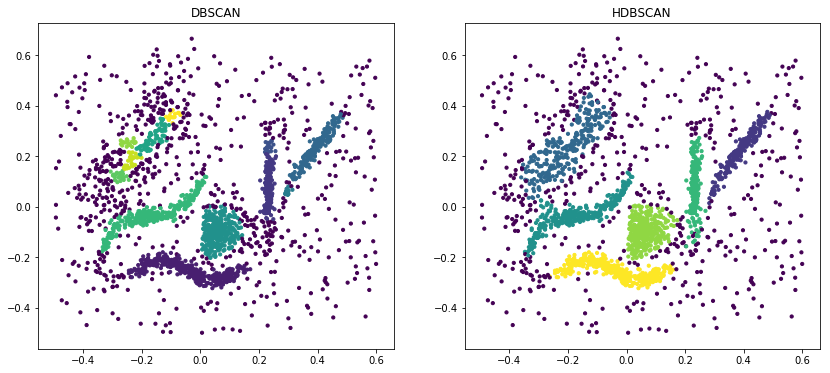

In [20]:
dbscan = DBSCAN(eps=.02, min_samples=10)
hdbscan = HDBSCAN(min_cluster_size=15, gen_min_span_tree=True)
db_clusters = dbscan.fit_predict(alternative_data)
hdb_clusters = hdbscan.fit_predict(alternative_data)
fig, axes = plt.subplots(ncols=2, figsize=(14,6))
axes[0].scatter(*alternative_data.T, c=db_clusters, s=10, cmap=cmap)
axes[0].set_title('DBSCAN')
axes[1].scatter(*alternative_data.T, c=hdb_clusters, s=10, cmap=cmap)
axes[1].set_title('HDBSCAN');

### HDBSCAN: Density-based Dendrogram 

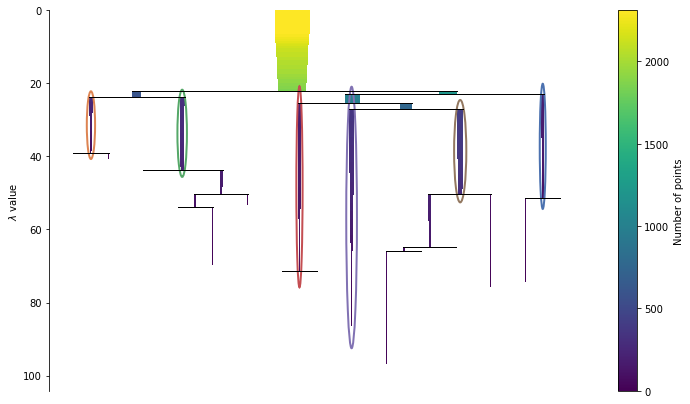

In [23]:
fig, ax = plt.subplots(figsize=(12,7))
hdbscan.condensed_tree_.plot(select_clusters=True,
                        selection_palette=sns.color_palette('deep', 8));

### Minimum Spanning Tree

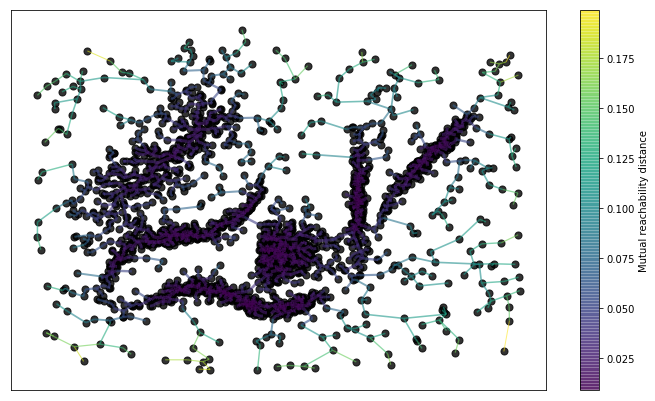

In [24]:
fig, ax = plt.subplots(figsize=(12,7))
hdbscan.minimum_spanning_tree_.plot(edge_cmap='viridis',
                                      edge_alpha=0.6,
                                      node_size=50,
                                      edge_linewidth=1);